Mock related plots
----
In the following, we show the code we used to reproduces the figures illustrating our mock setup

In [1]:
import numpy as np
import os
import time
import copy
import corner
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.LensModel.Profiles.pemd import PEMD
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

np.random.seed(seed=int(time.time()))

# Constants in SI
G_const = 6.67 * 10**(-11)

# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.311
z_source = 1.722
Om = 0.3
OL = 0.7
H0 = 67.4

log10_flag = True # If true, shows the log10 of the convergence contours 

cosmo = FlatLambdaCDM(H0=H0, Om0=Om, Ob0=0.)
lens_cosmo = LensCosmo(z_lens = z_lens, z_source = z_source, cosmo = cosmo)
deltaPix = 0.05 #  pixel size in arcsec (area per pixel = deltaPix**2) 
numPix = 100  # Number of pixels (for Lens equation solver)

In [2]:
# Lensing Modelling
theta_E_true, gamma_true = 1.08, 2.17
e1true, e2true = -0.2, 0.05
kwargs_pemd = {'theta_E': theta_E_true, 'gamma': gamma_true, 'center_x': 0.0, 
               'center_y': 0.0, 'e1': e1true, 'e2': e2true}  # parameters of the deflector lens model

theta_E_inference, gamma_inference = 1.08, 2.18
kwargs_pemd_inference = {'theta_E': theta_E_inference, 'gamma': gamma_inference,'center_x': 0.0, 
                         'center_y': 0.0, 'e1': e1true, 'e2': e2true}  # inferred parameters of the deflector lens
kwargs_shear = {'gamma1': 0.05, 'gamma2': -0.02}  # shear values to the source plane
kwargs_shear_inference = {'gamma1': -0.1, 'gamma2': 0.03}  # inferred shear values to the source plane

# kwargs halo
Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=2*10**14, c=3.5)
rho0_true, Rs_true, c_true, r200_true, M200_true = lens_cosmo.nfw_angle2physical(Rs_angle=Rs_angle, 
                                                                                 alpha_Rs=alpha_Rs)
# Coordinate centers of the halo
x_nfw, y_nfw = 18, -10
x_nfw_inf, y_nfw_inf = -2.16, 25.5

kwargs_nfw_halo = {'Rs': Rs_angle, 'alpha_Rs': alpha_Rs, 'center_x': x_nfw, 'center_y': y_nfw}
kwargs_nfw_halo_ellipt = {'Rs': Rs_angle, 'alpha_Rs': alpha_Rs, 'center_x': x_nfw, 'center_y': y_nfw, 
                   'e1':-0.07, 'e2': 0.03} 
kwargs_nfw_halo_inf = {'Rs': Rs_angle, 'alpha_Rs': alpha_Rs, 'center_x': x_nfw_inf, 
                       'center_y': y_nfw_inf}  # Inferred parameters

lens_model_list = ['PEMD', 'SHEAR', 'NFW']
lens_model_list_ellipt = ['PEMD', 'SHEAR', 'NFW_ELLIPSE']

kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw_halo_ellipt]

lens_model_class = LensModel(lens_model_list=lens_model_list_ellipt, z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'
source_x, source_y = 5.9, -2.61
source_x_inf, source_y_inf = -0.49, 7.81


lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)

lens_model_class_pemd = LensModel(lens_model_list=['PEMD'], z_lens=z_lens, z_source=z_source, cosmo=cosmo)
lens_model_class_nfw_ellipt = LensModel(lens_model_list=['NFW_ELLIPSE'], z_lens=z_lens, z_source=z_source, cosmo=cosmo)
lens_model_class_nfw = LensModel(lens_model_list=['NFW'], z_lens=z_lens, z_source=z_source, cosmo=cosmo)

# Convergence map
x_pl = np.linspace(-3,3,60)
y_pl = np.linspace(-3,3,60)
x = np.linspace(-27,20,80)
y = np.linspace(-19,30,80)

# Parameters of the wrong posterior minima
Rs_angle1 = 19.99
alpha_Rs1 = 4.140749600715561
Rs_angle2 = 23.48
alpha_Rs2 = 5.1792129801063570
kwargs_nfw_halo1 = {'Rs': Rs_angle1, 'alpha_Rs': alpha_Rs1, 'center_x': -1.2643773139845393, 'center_y': 25.33769209348803}
kwargs_nfw_halo2 = {'Rs': Rs_angle2, 'alpha_Rs': alpha_Rs2, 'center_x': -21.98, 'center_y': -15.3}

In [3]:
# Build the convergence maps
if log10_flag == False:
    convergence_map_pemd = np.array([[lens_model_class_pemd.kappa(xi, yi, [kwargs_pemd]) for xi in x_pl ] for yi in y_pl])
    convergence_map_pemd_inference = [[lens_model_class_pemd.kappa(xi, yi, [kwargs_pemd_inference]) for xi in x_pl ] for yi in y_pl]
    convergence_map_nfw = np.array([[lens_model_class_nfw.kappa(xi, yi, [kwargs_nfw_halo]) for xi in x ] for yi in y])
    convergence_map_nfw_ellipt = np.array([[lens_model_class_nfw_ellipt.kappa(xi, yi, [kwargs_nfw_halo_ellipt])
                                            for xi in x ] for yi in y])

    convergence_map_nfw1 = np.array([[lens_model_class_nfw.kappa(xi, yi, [kwargs_nfw_halo1]) for xi in x ] for yi in y])
    convergence_map_nfw2 = np.array([[lens_model_class_nfw.kappa(xi, yi, [kwargs_nfw_halo2]) for xi in x ] for yi in y])
else:
    convergence_map_pemd = np.array([[np.log10(lens_model_class_pemd.kappa(xi, yi, [kwargs_pemd])) for xi in x_pl ] for yi in y_pl])
    convergence_map_pemd_inference = [[np.log10(lens_model_class_pemd.kappa(xi, yi, [kwargs_pemd_inference])) for xi in x_pl ] for yi in y_pl]
    convergence_map_nfw = np.array([[np.log10(lens_model_class_nfw.kappa(xi, yi, [kwargs_nfw_halo])) for xi in x ] for yi in y])
    convergence_map_nfw_ellipt = np.array([[np.log10(lens_model_class_nfw_ellipt.kappa(xi, yi, [kwargs_nfw_halo_ellipt]))
                                     for xi in x ] for yi in y])
    convergence_map_nfw1 = np.array([[np.log10(lens_model_class_nfw.kappa(xi, yi, [kwargs_nfw_halo1])) for xi in x ] for yi in y])
    convergence_map_nfw2 = np.array([[np.log10(lens_model_class_nfw.kappa(xi, yi, [kwargs_nfw_halo2])) for xi in x ] for yi in y])
source_x1, source_y1 = -0.4, 12
source_x2, source_y2 = -4, -3

x, y = np.meshgrid(x,y)
x_pl, y_pl = np.meshgrid(x_pl,y_pl)

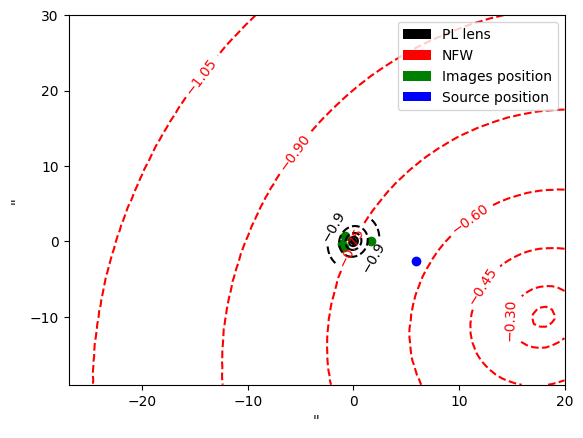

In [4]:
# Plot the mock setup

cset1 = plt.contour(x_pl, y_pl, convergence_map_pemd, colors='k')
cset2 = plt.contour(x, y, convergence_map_nfw_ellipt, colors='r')
plt.clabel(cset1, inline=True)
plt.clabel(cset2, inline=True)
plt.scatter(x_image, y_image, color='green', label='Images')
plt.scatter(source_x, source_y, color='blue', label='Source')
plt.xlabel("''")
plt.ylabel("''")
proxy = [plt.Rectangle((1, 1), 2, 2, fc=color_i) for color_i in ['black','red', 'green', 'blue']]
plt.legend(proxy, ["PL lens", "NFW", 'Images position', "Source position"])
plt.show()

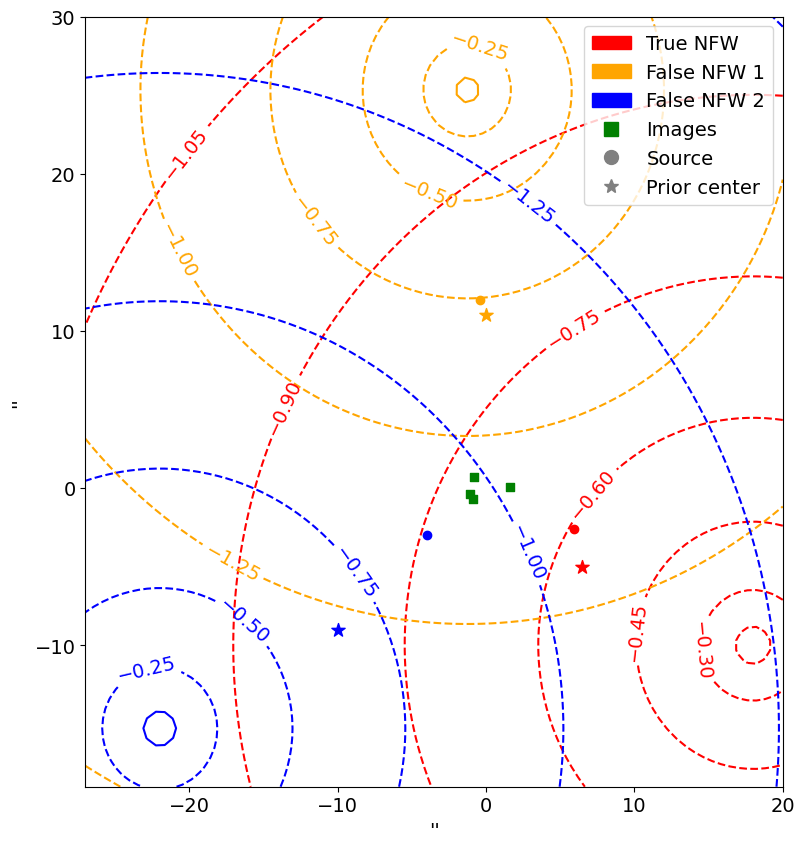

In [5]:
# Plot the inference plot
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(9,10))
cset2 = plt.contour(x, y, convergence_map_nfw, colors='r')
cset_halo1 = plt.contour(x, y, convergence_map_nfw1, colors='orange')
cset_halo2 = plt.contour(x, y, convergence_map_nfw2, colors='blue')
plt.clabel(cset2, inline=True)
plt.clabel(cset_halo1, inline=True)
plt.clabel(cset_halo2, inline=True)

plt.scatter(x_image, y_image, color='green', marker='s', label='Images')
plt.scatter(source_x, source_y, color='red', label='Source')
plt.scatter(source_x1, source_y1, color='orange')
plt.scatter(source_x2, source_y2, color='blue')

plt.scatter(6.5, -5, 100, color='red', marker='*')
plt.scatter(0, 11, 100, color='orange', marker='*')
plt.scatter(-10, -9, 100, color='blue', marker='*')

plt.xlabel("''")
plt.ylabel("''")
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
gray_dot = mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=10)
green_square = mlines.Line2D([], [], color='green', marker='s', linestyle='None', markersize=10)
gray_star = mlines.Line2D([], [], color='gray', marker='*', linestyle='None', markersize=10)
proxy = [mpatches.Patch(color=color_i) for color_i in ['red', 'orange', 'blue']] + [green_square, gray_dot, gray_star]
plt.legend(proxy, ["True NFW", "False NFW 1", "False NFW 2", "Images", "Source", "Prior center"])
#plt.savefig('plots_other/convergence_map_full.pdf')
plt.show()